# Analyse BlueSeis BSPF Events

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np

from obspy.clients.fdsn import Client

from functions.request_data import __request_data
from functions.compute_adr_pfo import __compute_adr_pfo
from functions.compute_beamforming_pfo import __compute_beamforming_pfo

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
config = {}

## output path for figures
config['path_to_figs'] = data_path+"BSPF/figures/M21_event/"


## BSPF coordinates
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

## Event M21
config['tbeg'] = obs.UTCDateTime("2023-09-11 09:20:10")
config['tend'] = obs.UTCDateTime("2023-09-11 09:20:30")

# config['fmin'] = 1
# config['fmax'] = 5.0

## Load Data

In [4]:
event = Client("USGS").get_events(starttime=config['tbeg'], endtime=config['tend'])
event = event[0]

## Eventtime
config['eventtime'] = event.origins[0].time

In [5]:
event

Event:	2023-09-11T09:20:15.690000Z | +33.507, -116.473 | 2.13 ml | manual

	            resource_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/fdsnws/event/1/query?eventid=ci39662530&format=quakeml")
	             event_type: 'earthquake'
	          creation_info: CreationInfo(agency_id='ci', creation_time=UTCDateTime(2023, 9, 11, 18, 26, 10, 260000), version='6')
	    preferred_origin_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/product/origin/ci39662530/ci/1694456722130/product.xml")
	 preferred_magnitude_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/product/origin/ci39662530/ci/1694456722130/product.xml#magnitude")
	                   ---------
	     event_descriptions: 1 Elements
	                origins: 1 Elements
	             magnitudes: 1 Elements

In [6]:
st0 = obs.read("./event21_6c.mseed")

# for tr in st0:
#     if "BSPF" in tr.stats.station:
#         tr.data = np.roll(tr.data, -10)

submask = "inner"

bspf0 = st0.select(station="BSPF").copy()
pfo0 = st0.select(station="PFO*").copy()
adr0 = st0.select(station="RPFO", location=submask[:2]).copy()

In [7]:
# ##load rotation
# bspf0, bspf_inv = __request_data("PY.BSPF..HJ*", config['tbeg'], config['tend'])
# bspf0.resample(40);

# ## load translation
# pfo0, pfo_inv = __request_data("II.PFO.10.BH*", config['tbeg'], config['tend'], translation_type="ACC")

# # merge to one stream
# st0 = bspf0.copy();
# st0 += pfo0.copy();

# ## ADR
# submask = "inner"
# adr0, status = __compute_adr_pfo(config['tbeg'], config['tend'], submask=submask, status=True)
# for tr in adr0:
#     tr.stats.location = "in"
# st0 += adr0.copy();

# submask = "mid"
# adr0, status = __compute_adr_pfo(config['tbeg'], config['tend'], submask=submask, status=True)
# for tr in adr0:
#     tr.stats.location = "mi"
# st0 += adr0.copy();

# submask = "all"
# adr0, status = __compute_adr_pfo(config['tbeg'], config['tend'], submask=submask, status=True)
# for tr in adr0:
#     tr.stats.location = "al"
# st0 += adr0.copy();


# st0.trim(config['tbeg']+1, config['tend']-1)

# st0.write("./event21_6c.mseed", format="MSEED")

# # st0.plot(equal_scale=False);

In [8]:
# st0.plot(equal_scale=False);

## Create stream for all data

In [9]:
def __makeplot_waveform_comparison(bspf, adr, submask):

    from obspy.signal.cross_correlation import correlate

    fig, ax = plt.subplots(3, 1, figsize=(15, 5))

    font = 14

    ax[0].plot(bspf.select(channel="*Z")[0].times(), bspf.select(channel="*Z")[0].data, label="BSPF Z")
    ax[0].plot(adr.select(channel="*Z")[0].times(), adr.select(channel="*Z")[0].data, label="ADR Z")

    ax[1].plot(bspf.select(channel="*N")[0].times(), bspf.select(channel="*N")[0].data, label="BSPF N")
    ax[1].plot(adr.select(channel="*N")[0].times(), adr.select(channel="*N")[0].data, label="ADR N")

    ax[2].plot(bspf.select(channel="*E")[0].times(), bspf.select(channel="*E")[0].data, label="BSPF E")
    ax[2].plot(adr.select(channel="*E")[0].times(), adr.select(channel="*E")[0].data, label="ADR E")

    cc_Z = round(correlate(bspf.select(channel="*Z")[0].data, adr.select(channel="*Z")[0].data, 0, demean=True, normalize='naive', method='auto')[0], 1)
    cc_N = round(correlate(bspf.select(channel="*N")[0].data, adr.select(channel="*N")[0].data, 0, demean=True, normalize='naive', method='auto')[0], 1)
    cc_E = round(correlate(bspf.select(channel="*E")[0].data, adr.select(channel="*E")[0].data, 0, demean=True, normalize='naive', method='auto')[0], 1)

    for i in range(3):
        ax[i].legend(loc=1, ncols=4)
        ax[i].grid(which="both", alpha=0.5)
        # ax[i].set_xscale("log")
        ax[i].set_ylabel("rot. rate (rad/s)")

    ax[2].set_xlabel("Frequency (Hz)")
    ax[0].set_title(f"{config['tbeg'].date} | {config['fmin']}-{config['fmax']} Hz | ADR {submask} | CCz = {cc_Z} | CCn = {cc_N} | CCe = {cc_E}")

    plt.show();
    return fig

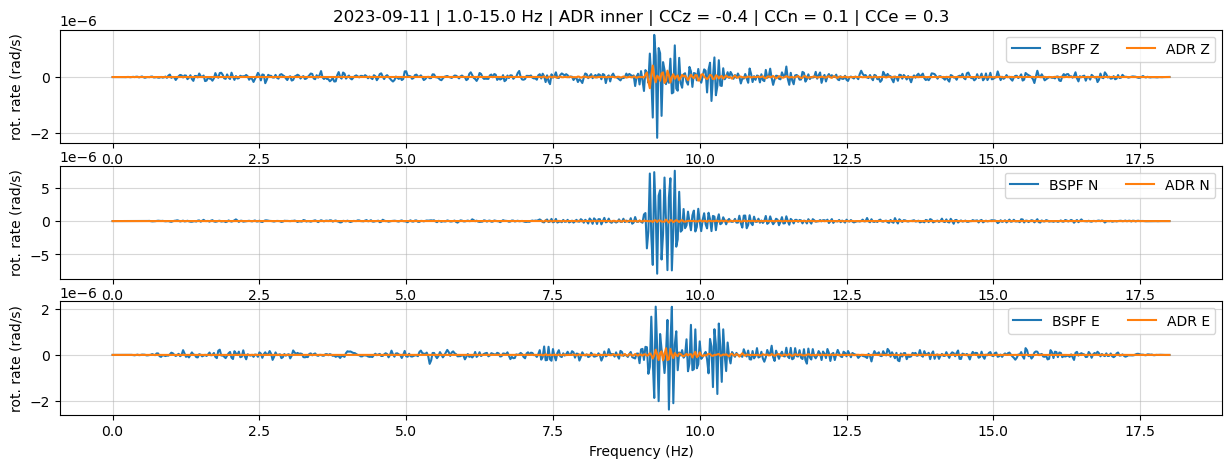

In [10]:
config['fmin'] = 1.0
config['fmax'] = 15.0


bspf = bspf0.copy()
bspf = bspf.detrend("simple").taper(0.1).filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'])

adr = adr0.copy()
adr = adr.detrend("simple").taper(0.1).filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax']);

pfo = pfo0.copy()
pfo = pfo.detrend("simple").taper(0.1).filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'])


fig = __makeplot_waveform_comparison(bspf, adr, submask)

fig.savefig(config['path_to_figs']+f"BSPF_M21_waveforms_{submask}.png", format="png", dpi=200, bbox_inches='tight');

In [11]:
from functions.compute_cross_wavelet_transform import __compute_cross_wavelet_transform

3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-09-11T09:20:11.002400Z - 2023-09-11T09:20:29.002400Z | 40.0 Hz, 721 samples
PY.BSPF..HJN | 2023-09-11T09:20:11.002400Z - 2023-09-11T09:20:29.002400Z | 40.0 Hz, 721 samples
PY.BSPF..HJE | 2023-09-11T09:20:11.002400Z - 2023-09-11T09:20:29.002400Z | 40.0 Hz, 721 samples

3 Trace(s) in Stream:
PY.RPFO.mi.BJZ | 2023-09-11T09:20:11.000000Z - 2023-09-11T09:20:29.000000Z | 40.0 Hz, 721 samples
PY.RPFO.mi.BJN | 2023-09-11T09:20:11.000000Z - 2023-09-11T09:20:29.000000Z | 40.0 Hz, 721 samples
PY.RPFO.mi.BJE | 2023-09-11T09:20:11.000000Z - 2023-09-11T09:20:29.000000Z | 40.0 Hz, 721 samples

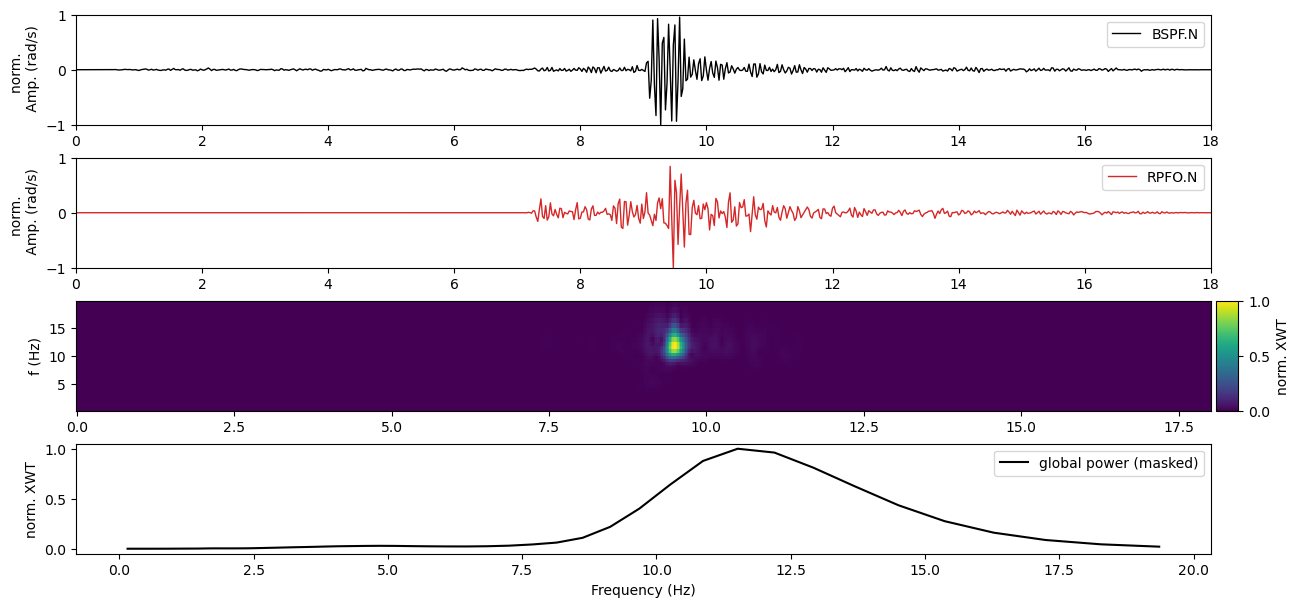

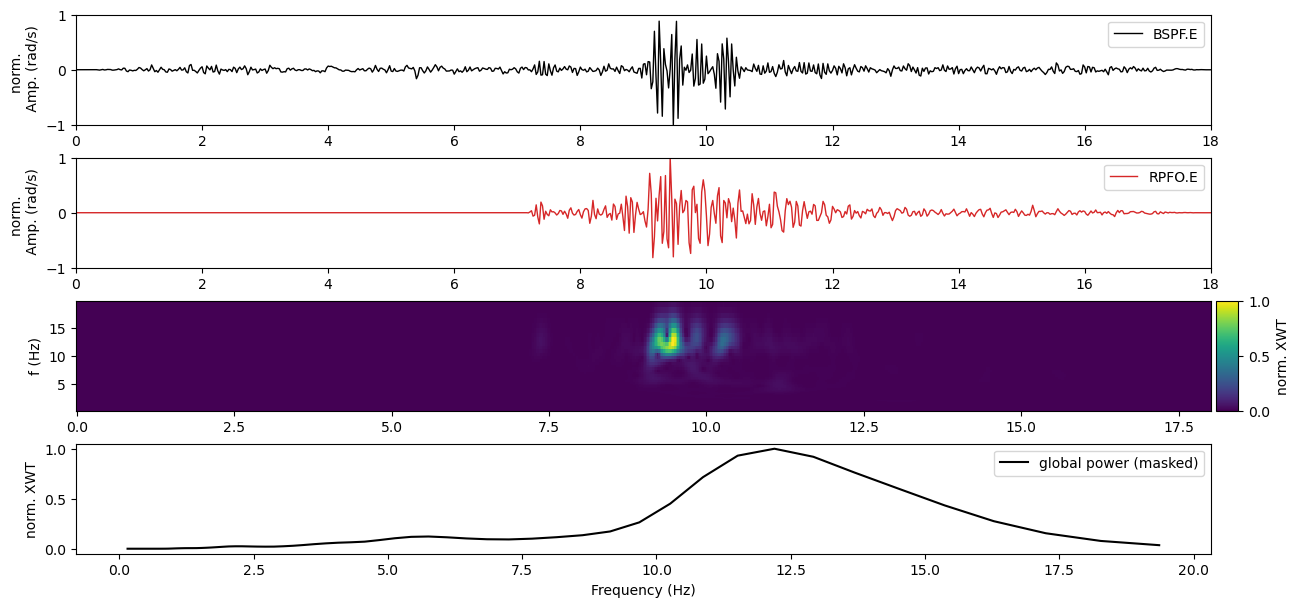

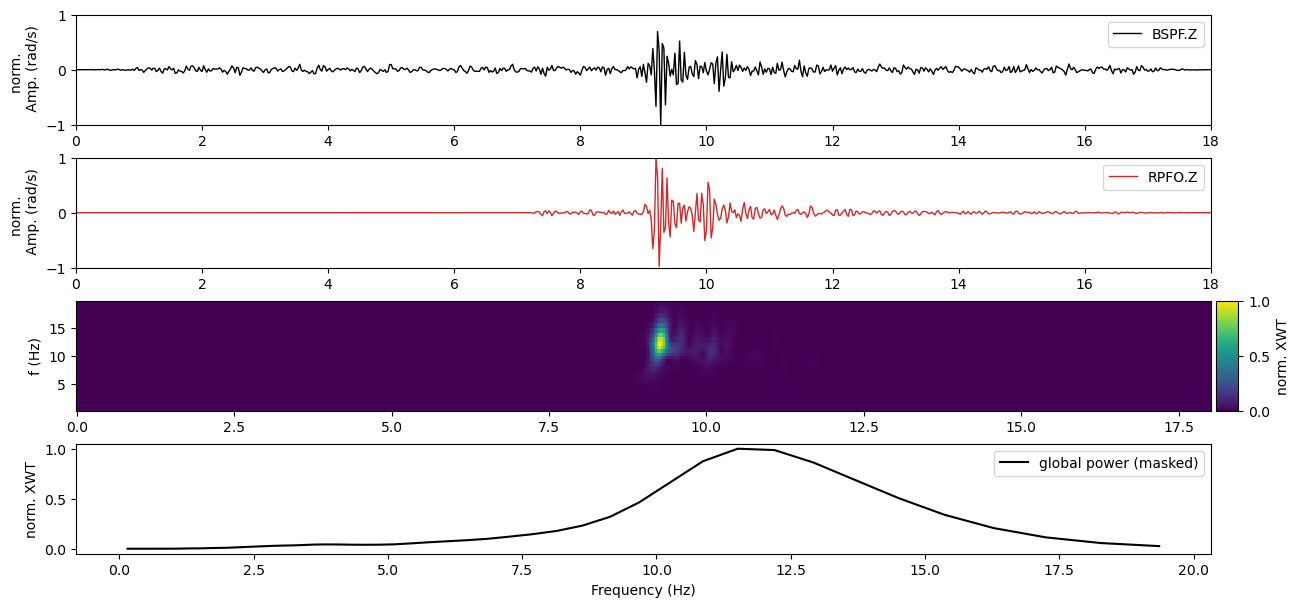

In [12]:
acc = st0.select(station="PFO*").copy().detrend("demean")
rot = st0.select(station="BSPF").copy().detrend("demean")
adr = st0.select(station="RPFO", location="mi").copy().detrend("demean")

config['fmin'] = 1.0 # 1.3 # 0.3
config['fmax'] = 15.0 # 15.0 # 3.0

rot.detrend("simple").taper(0.1).filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'])
adr.detrend("simple").taper(0.1).filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'])


# comp = "N"

for comp in ["N", "E", "Z"]:

    labels = [rot.select(channel=f"*{comp}")[0].stats.station+"."+comp, adr.select(channel=f"*{comp}")[0].stats.station+"."+comp]

    out = __compute_cross_wavelet_transform(
                                        rot[0].times(),
                                        rot.select(channel=f"*{comp}")[0].data,
                                        adr.select(channel=f"*{comp}")[0].data,
                                        rot[0].stats.delta,
                                        datalabels=labels,
                                        xwt_threshold=0.,
                                        fmax_limit=config['fmax'],
                                        normalize=True,
                                        plot=True,
    )

    out['fig'].savefig(config['path_to_figs']+f"BSPF_M21_xwt_{comp}_{config['fmin']}_{config['fmax']}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


In [13]:
from functions.compute_wavelet_coherencey_transform import __compute_wavelet_coherency_transform

/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/pycwt/wavelet.py:633: RuntimeWarning: invalid value encountered in arctanh
  aa = numpy.round(numpy.arctanh(numpy.array([al1, al2]) * 4))
/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/pycwt/wavelet.py:254: RuntimeWarning: invalid value encountered in log2
  dj = numpy.log2(scales[1] / scales[0])
/home/brotzer/notebooks/BSPF/functions/compute_wavelet_coherencey_transform.py:119: RuntimeWarning: Mean of empty slice
  global_power_f = nan_to_num(nanmean(wct_power_masked,axis=1), nan=0)
/home/brotzer/notebooks/BSPF/functions/compute_wavelet_coherencey_transform.py:120: RuntimeWarning: Mean of empty slice
  global_power_t = nan_to_num(nanmean(wct_power_masked,axis=0), nan=0)


NOTE: WCT significance loaded from cache.

0.008021880045733717 0.00979202775664734


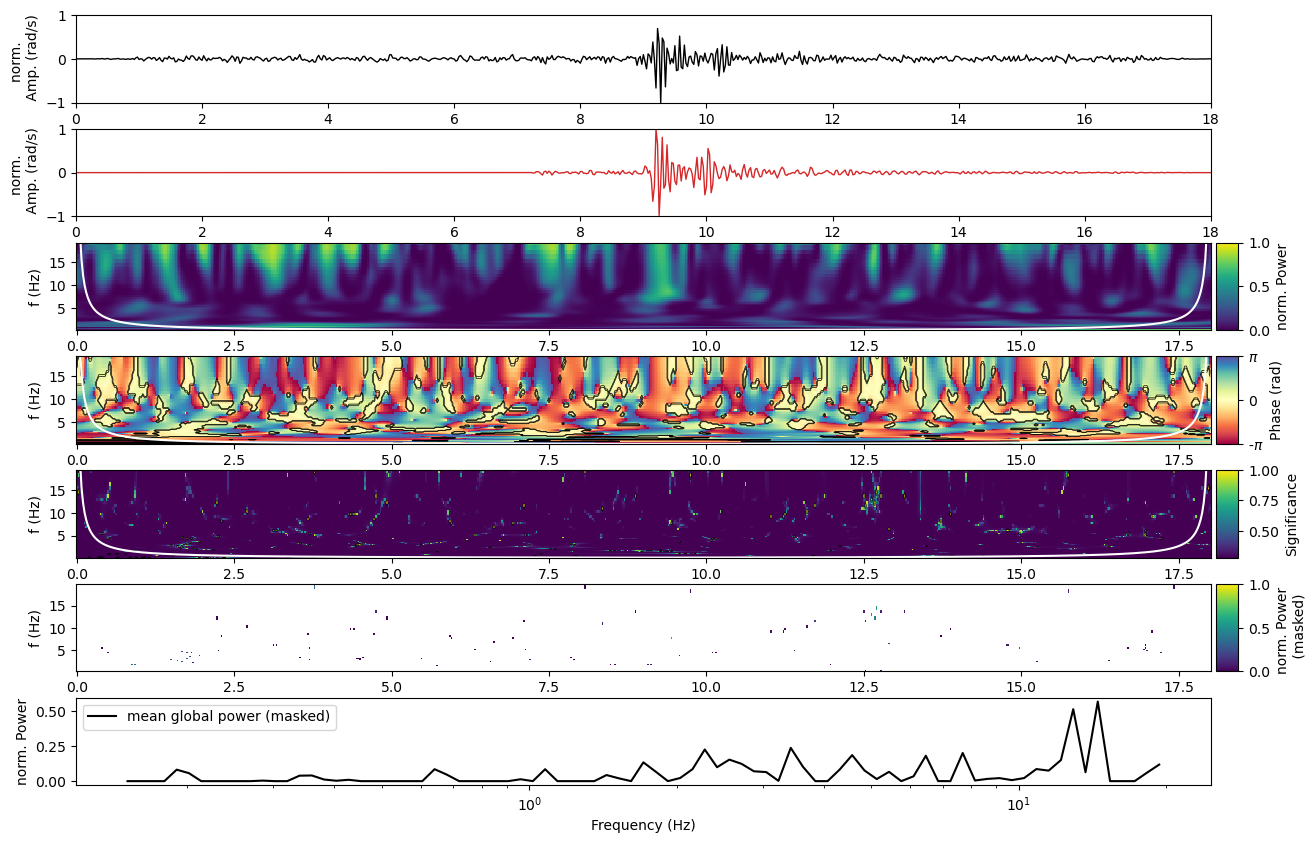

In [14]:
out_wct = __compute_wavelet_coherency_transform(
                                            rot[0].times(),
                                            rot.select(channel=f"*{comp}")[0].data,
                                            adr.select(channel=f"*{comp}")[0].data,
                                            rot[0].stats.delta,
                                            fmax_limit=config['fmax'],
                                            normalize=True,
                                            plot=True,
)

# out_wct['fig'].savefig(config['path_to_figs']+f"BSPF_M21_wct_{comp}_{config['fmin']}_{config['fmax']}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


## Coherence in Octaves

In [15]:
from functions.makeplot_coherence_octaves import __coherence_in_octaves

15 Trace(s) in Stream:
PY.BSPF..HJZ   | 2023-09-11T09:20:11.002400Z - 2023-09-11T09:20:29.002400Z | 40.0 Hz, 721 samples
PY.BSPF..HJN   | 2023-09-11T09:20:11.002400Z - 2023-09-11T09:20:29.002400Z | 40.0 Hz, 721 samples
PY.BSPF..HJE   | 2023-09-11T09:20:11.002400Z - 2023-09-11T09:20:29.002400Z | 40.0 Hz, 721 samples
II.PFO.10.BHZ  | 2023-09-11T09:20:10.994538Z - 2023-09-11T09:20:28.994538Z | 40.0 Hz, 721 samples
II.PFO.10.BHN  | 2023-09-11T09:20:10.994538Z - 2023-09-11T09:20:28.994538Z | 40.0 Hz, 721 samples
II.PFO.10.BHE  | 2023-09-11T09:20:10.994538Z - 2023-09-11T09:20:28.994538Z | 40.0 Hz, 721 samples
PY.RPFO.in.BJZ | 2023-09-11T09:20:11.000000Z - 2023-09-11T09:20:29.000000Z | 40.0 Hz, 721 samples
PY.RPFO.in.BJN | 2023-09-11T09:20:11.000000Z - 2023-09-11T09:20:29.000000Z | 40.0 Hz, 721 samples
PY.RPFO.in.BJE | 2023-09-11T09:20:11.000000Z - 2023-09-11T09:20:29.000000Z | 40.0 Hz, 721 samples
PY.RPFO.mi.BJZ | 2023-09-11T09:20:11.000000Z - 2023-09-11T09:20:29.000000Z | 40.0 Hz, 721 sampl

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


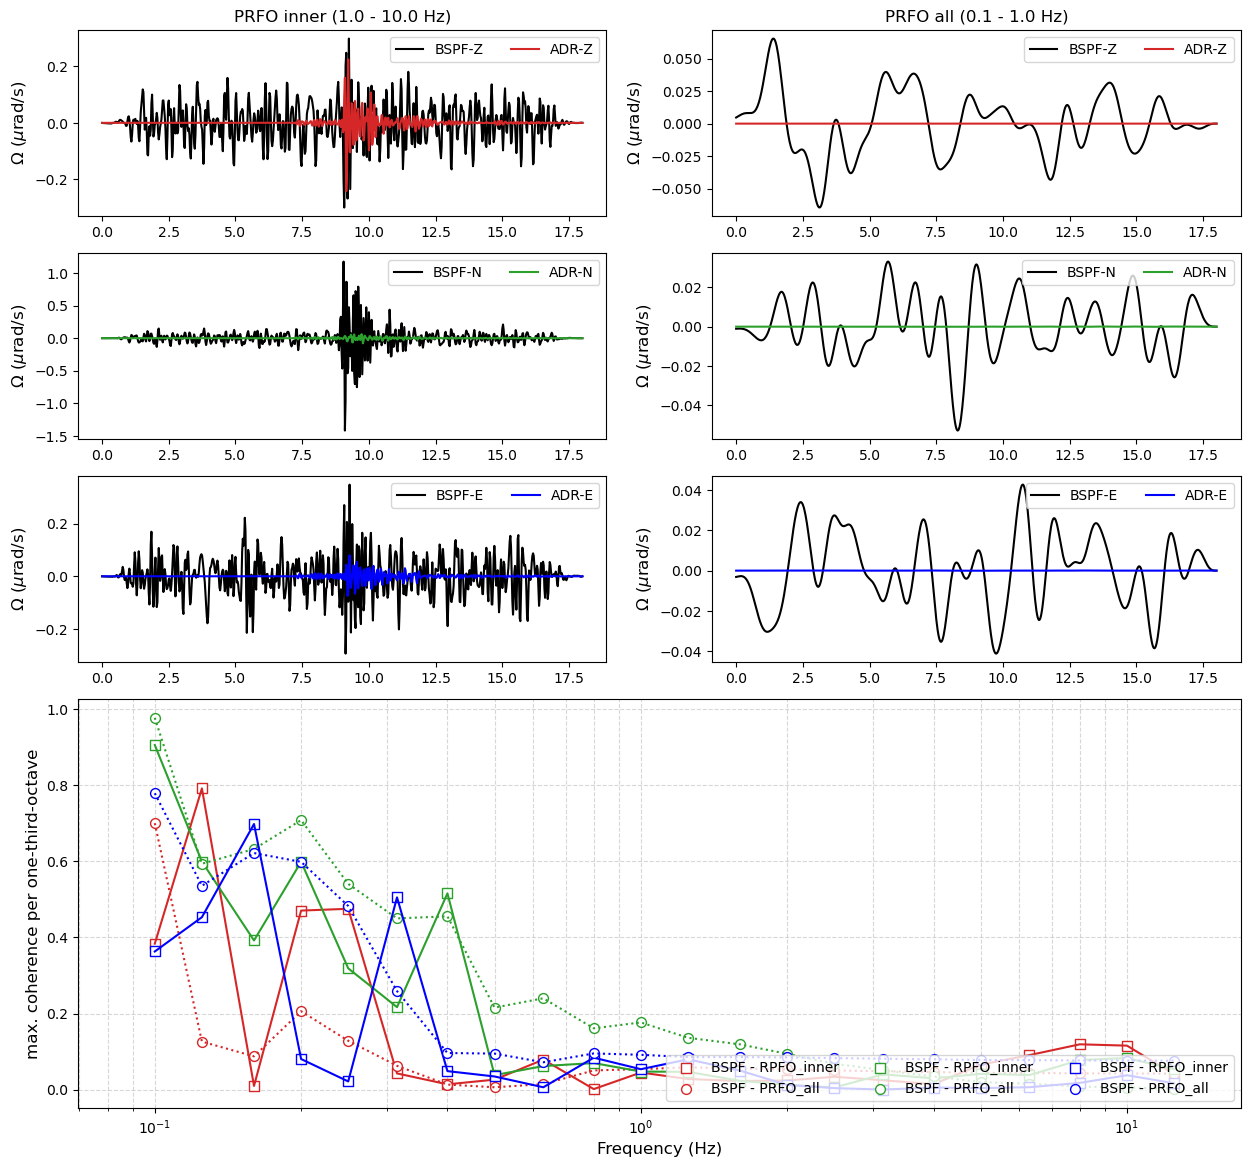

In [16]:
st = st0.copy();

fmin, fmax = 0.1, 12.0

st.detrend("simple").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)

out_coh = __coherence_in_octaves(st, fmin, fmax, normalize=False, plot=True)

out_coh['fig'].savefig(config['path_to_figs']+f"BSPF_M21_coherence.png", dpi=200, bbox_inches='tight', pad_inches=0.05)

## Backazimuth

In [17]:
from functions.compute_backazimuth import __compute_backazimuth

In [18]:
acc = st0.select(station="PFO*").copy()
rot = st0.select(station="BSPF").copy()

fmin, fmax = config['fmin'], config['fmax']

rot.detrend("simple").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)
acc.detrend("simple").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-09-11T09:20:11.002400Z - 2023-09-11T09:20:29.002400Z | 40.0 Hz, 721 samples
PY.BSPF..HJN | 2023-09-11T09:20:11.002400Z - 2023-09-11T09:20:29.002400Z | 40.0 Hz, 721 samples
PY.BSPF..HJE | 2023-09-11T09:20:11.002400Z - 2023-09-11T09:20:29.002400Z | 40.0 Hz, 721 samples

3 Trace(s) in Stream:
II.PFO.10.BHZ | 2023-09-11T09:20:10.994538Z - 2023-09-11T09:20:28.994538Z | 40.0 Hz, 721 samples
II.PFO.10.BHN | 2023-09-11T09:20:10.994538Z - 2023-09-11T09:20:28.994538Z | 40.0 Hz, 721 samples
II.PFO.10.BHE | 2023-09-11T09:20:10.994538Z - 2023-09-11T09:20:28.994538Z | 40.0 Hz, 721 samples

In [19]:
config['station_longitude'] = config['BSPF_lon']
config['station_latitude']  = config['BSPF_lat']

## specify window length for baz estimation in seconds
config['win_length_sec'] = 1/fmin

## define an overlap for the windows in percent (50 -> 50%)
config['overlap'] = 50

## specify steps for degrees of baz
config['step'] = 1

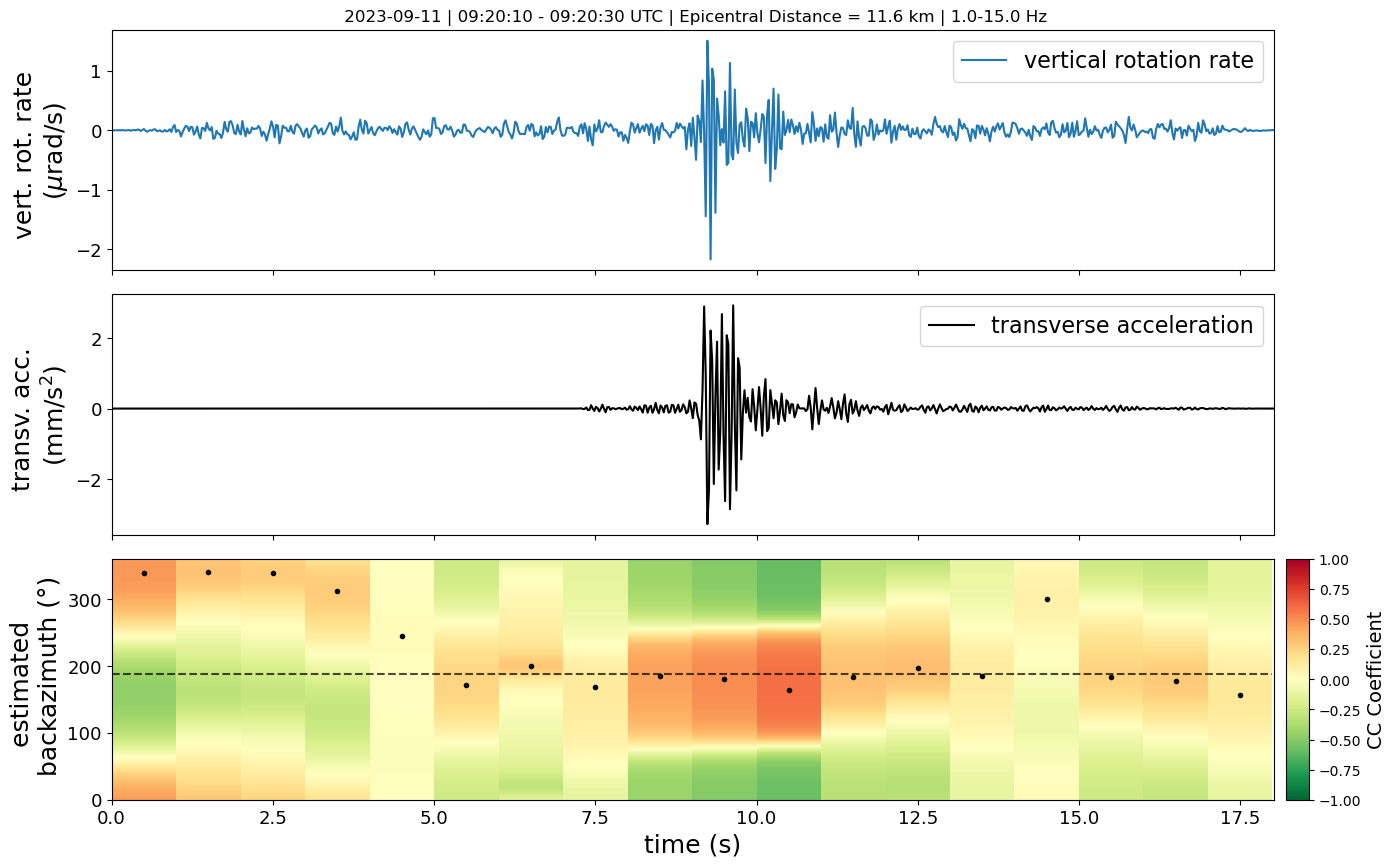

In [20]:
out = __compute_backazimuth(
                            acc,
                            rot,
                            config,
                            wave_type='love',
                            event=event,
                            plot=True,
                            flim=(fmin, fmax),
                            show_details=False,
)

out['fig'].savefig(config['path_to_figs']+f"BSPF_M21_baz_love_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


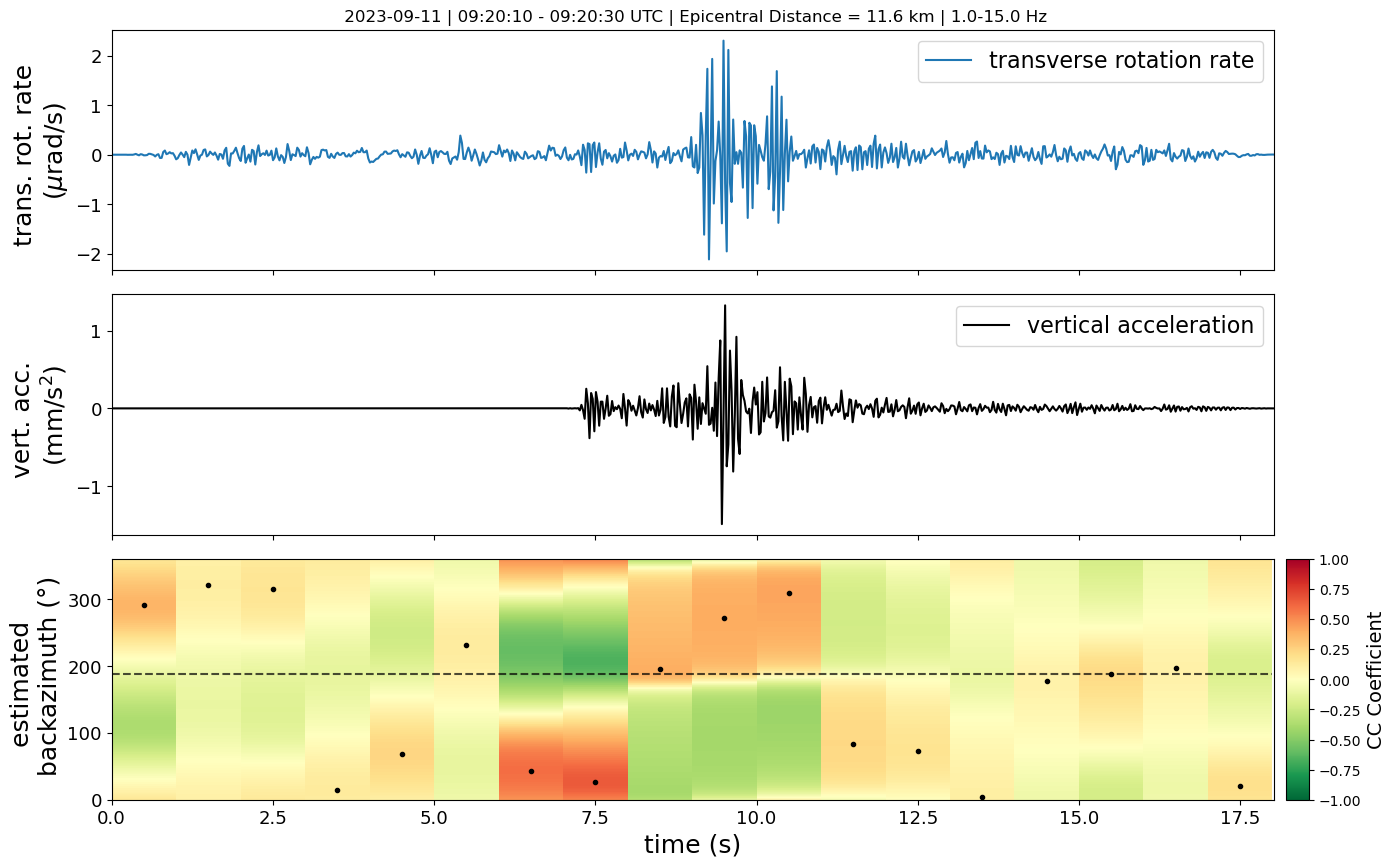

In [21]:
out = __compute_backazimuth(
                            acc,
                            rot,
                            config,
                            wave_type='rayleigh',
                            event=event,
                            plot=True,
                            flim=(fmin, fmax),
                            show_details=False,
)

out['fig'].savefig(config['path_to_figs']+f"BSPF_M21_baz_rayleigh_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


In [22]:
from functions.get_theoretical_backazimuth import __get_theoretical_backazimuth

In [23]:
config['event'] = event

baz, az, dist = __get_theoretical_backazimuth(config['BSPF_lat'], config['BSPF_lon'], event_obj=event, fdsn_client='USGS')

In [24]:
from functions.compute_backazimuth_tangent import __compute_backazimuth_tangent

In [25]:
acc = st0.select(station="PFO*").copy()
rot = st0.select(station="BSPF").copy()
# rot = st0.select(station="RPFO", location="in").copy()

fmin, fmax = config['fmin'], config['fmax']


rot.detrend("simple").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)
acc.detrend("simple").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-09-11T09:20:11.002400Z - 2023-09-11T09:20:29.002400Z | 40.0 Hz, 721 samples
PY.BSPF..HJN | 2023-09-11T09:20:11.002400Z - 2023-09-11T09:20:29.002400Z | 40.0 Hz, 721 samples
PY.BSPF..HJE | 2023-09-11T09:20:11.002400Z - 2023-09-11T09:20:29.002400Z | 40.0 Hz, 721 samples

3 Trace(s) in Stream:
II.PFO.10.BHZ | 2023-09-11T09:20:10.994538Z - 2023-09-11T09:20:28.994538Z | 40.0 Hz, 721 samples
II.PFO.10.BHN | 2023-09-11T09:20:10.994538Z - 2023-09-11T09:20:28.994538Z | 40.0 Hz, 721 samples
II.PFO.10.BHE | 2023-09-11T09:20:10.994538Z - 2023-09-11T09:20:28.994538Z | 40.0 Hz, 721 samples

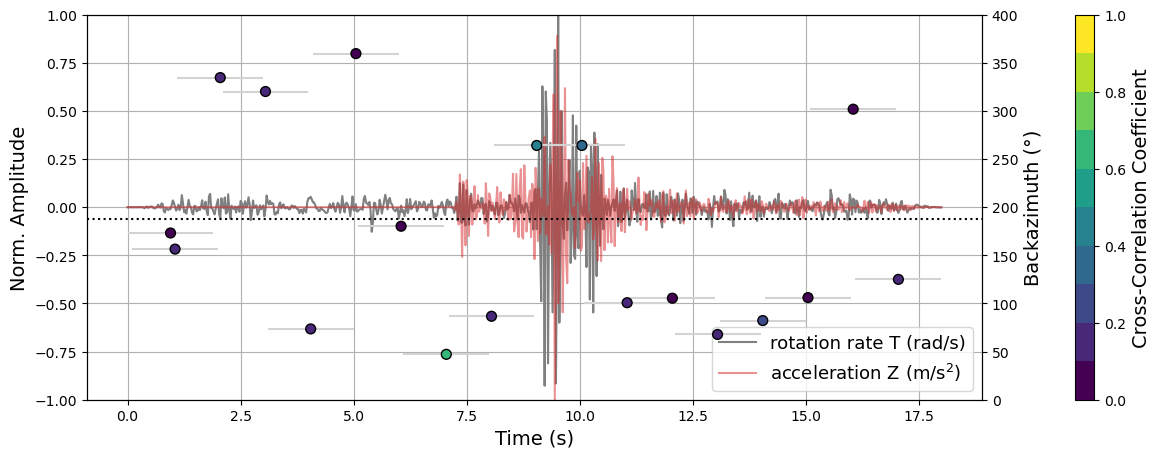

In [26]:
out = __compute_backazimuth_tangent(
                                    rot,
                                    acc,
                                    win_time_s=1/fmin,
                                    overlap=0.9,
                                    baz_theo=baz,
                                    cc_thres=0,
                                    plot=True,
                                    )

out['fig'].savefig(config['path_to_figs']+f"BSPF_M21_baz_tangent_{rot[0].stats.station}{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)

## Compare Backazimuth Codes

In [27]:
from functions.compare_backazimuth_codes import __compare_backazimuth_codes

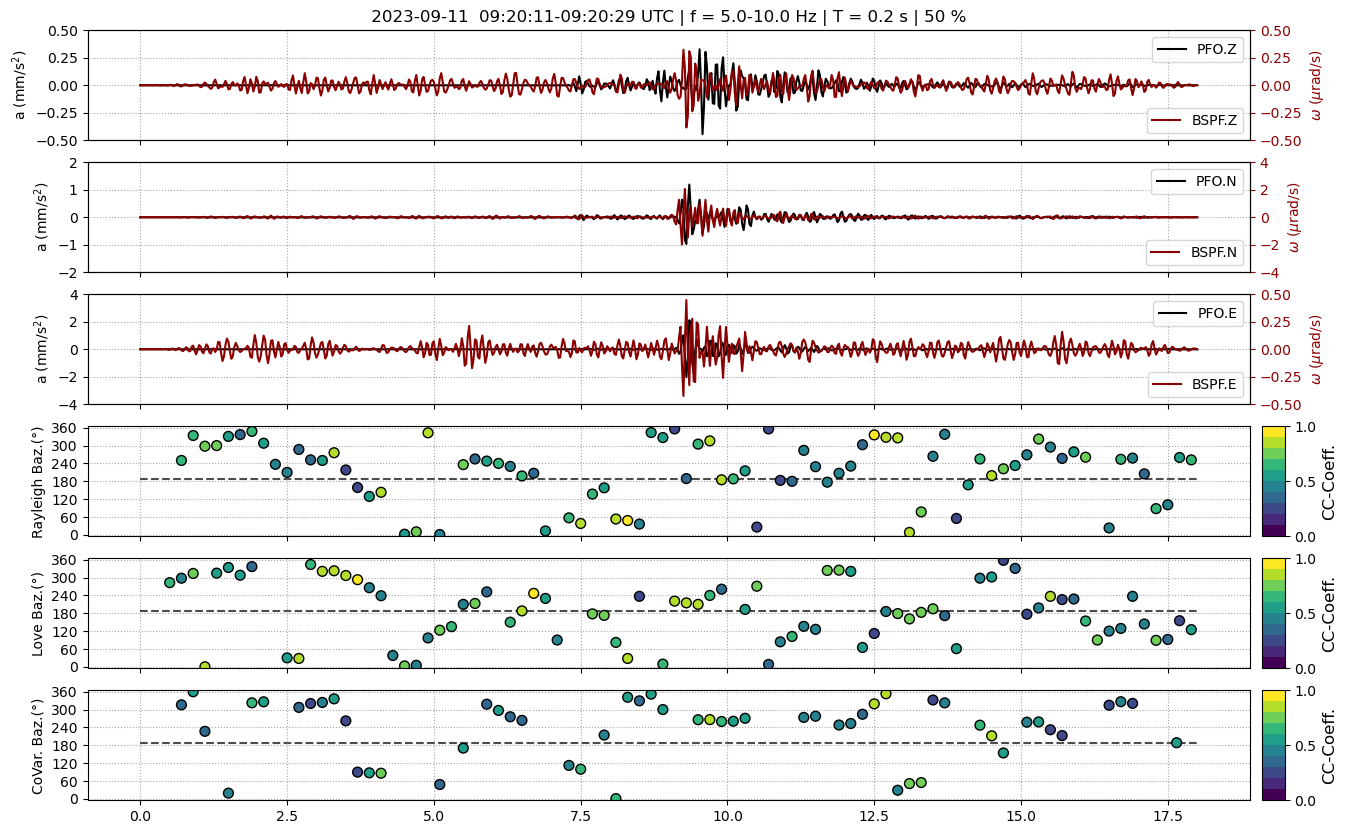

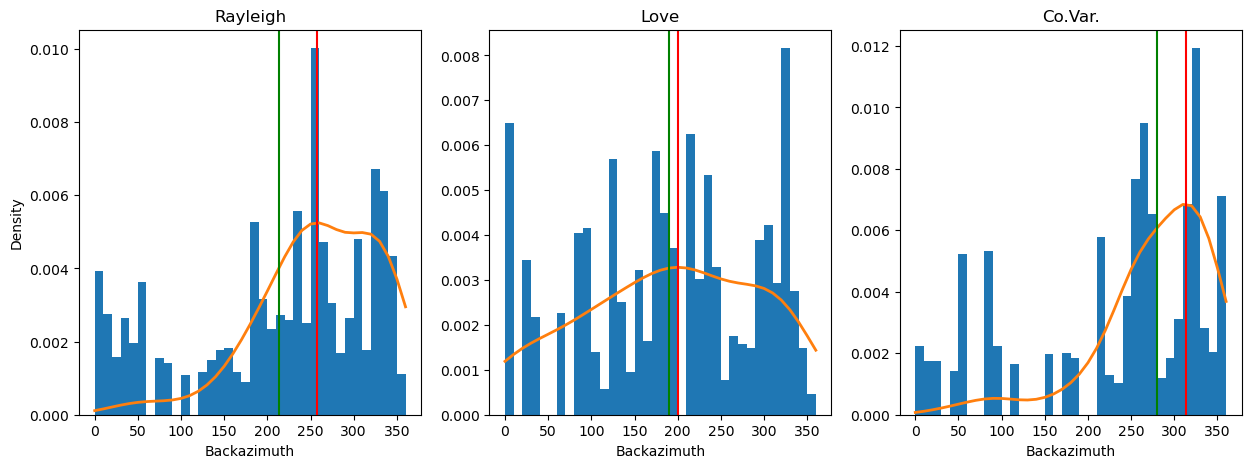

In [28]:
st = st0.copy();

acc = st.select(station="PFO*");
rot = st.select(station="BSPF");
# rot = st.select(station="RPFO", location="in");
# rot = st.select(station="RPFO", location="mi");
# rot = st.select(station="RPFO", location="al");

# fmin, fmax = config['fmin'], config['fmax']
fmin, fmax = 5.0, 10.0

out = __compare_backazimuth_codes(rot, acc, event, fmin, fmax, cc_thres=0.2, plot=True);

out['fig1'].savefig(config['path_to_figs']+f"BSPF_M21_baz_comparison_{rot[0].stats.location}_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05);
out['fig2'].savefig(config['path_to_figs']+f"BSPF_M21_baz_comparison_{rot[0].stats.location}_{fmin}_{fmax}_his2.png", dpi=200, bbox_inches='tight', pad_inches=0.05);

## Compare backazimuth estimate for ADR, BSPF and Beamforming

In [29]:
from functions.compute_beamforming_pfo import __compute_beamforming_pfo

In [30]:
stt = st0.copy();

acc = stt.copy().select(station="PFO*");

## ____________________
## direct rotation
rot = stt.copy().select(station="BSPF");
out_bspf_i = __compare_backazimuth_codes(rot, acc, event, 1.0, 12.0, cc_thres=0.2, plot=False);

# rot = stt.copy().select(station="BSPF");
# out_bspf_m = __compare_backazimuth_codes(rot, acc, event, 0.5, 2.0, cc_thres=0.2, plot=False);

# rot = stt.copy().select(station="BSPF");
# out_bspf_a = __compare_backazimuth_codes(rot, acc, event, 0.3, 1.0, cc_thres=0.2, plot=False);

# rot = stt.copy().select(station="BSPF");
# out_bspf_o = __compare_backazimuth_codes(rot, acc, event, 0.8, 2.0, cc_thres=0.2, plot=False);

# out = __compare_backazimuth_codes(rot, acc, event, fmin, fmax, cc_thres=0.2, plot=True);


## ____________________
## adr rotation
rot = stt.copy().select(station="RPFO", location="in");
out_adr_i = __compare_backazimuth_codes(rot, acc, event, 1.0, 12.0, cc_thres=0.2, plot=False);

# rot = stt.copy().select(station="RPFO", location="mi");
# out_adr_m = __compare_backazimuth_codes(rot, acc, event, 0.5, 2.0, cc_thres=0.2, plot=False);

# rot = stt.copy().select(station="RPFO", location="al");
# out_adr_a = __compare_backazimuth_codes(rot, acc, event, 0.3, 1.0, cc_thres=0.2, plot=False);

# rot = stt.copy().select(station="RPFO", location="mi");
# out_adr_o = __compare_backazimuth_codes(rot, acc, event, 0.8, 2.0, cc_thres=0.2, plot=False);

## ____________________
## array beamforming
out_bf_i = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=1.0, fmax=12.0, component="Z", submask="inner", plot=False)
# out_bf_m = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=0.5, fmax=2.0, component="Z", submask="mid", plot=False)
# out_bf_a = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=0.3, fmax=1.0, component="Z", submask="all", plot=False)
# out_bf_o = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=0.8, fmax=2.0, component="Z", submask="mid", plot=False)


 -> obtained: 5 of 5 stations!

 -> Runtime: 0.31 minutes


In [31]:
def __makeplot_comparison():

    labels = ["iBSPF", "iADR", "iBF", "mBSPF", "mADR", "mBF", "aBSPF", "aADR", "aBF", "BSPF", "ADR", "BF"]

    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    font = 12

    ax.axhline(out_bspf_i['baz_theo'], color="k", ls="--", label="theo. Baz.")
    ax.fill_between([-0.3, 4.0], out_bspf_i['baz_theo']-10, out_bspf_i['baz_theo']+10, color="yellow", alpha=0.5, label="theo. Baz. +- 10°")


    for j, out in enumerate([out_adr_i, out_adr_m, out_adr_a, out_adr_o]):

        ax.errorbar(j-0.02, out['baz_tangent_max'], yerr=out['baz_tangent_std'], color="tab:blue", zorder=2)
        ax.errorbar(j, out['baz_love_max'], yerr=out['baz_love_std'], color="tab:green", zorder=2)
        ax.errorbar(j+0.02, out['baz_rayleigh_max'], yerr=out['baz_rayleigh_std'], color="tab:red", zorder=2)

        ax.scatter(j-0.02, out['baz_tangent_max'], color="tab:blue", zorder=2, label="Co.Var.", edgecolors="k")
        ax.scatter(j, out['baz_love_max'], color="tab:green", zorder=2, label="Love", edgecolors="k")
        ax.scatter(j+0.02, out['baz_rayleigh_max'], color="tab:red", zorder=2, label="Rayleigh", edgecolors="k")

        ## plot only for legend icon

        if j == 0:
            ax.scatter(j+0.4, out_bf_i['baz_bf_max'], color="tab:orange", zorder=2, label="beamforming", edgecolors="k")
            ax.legend(loc=1)


    for j, out in enumerate([out_bspf_i, out_bspf_m, out_bspf_a, out_bspf_o]):

        ax.errorbar(j+0.18, out['baz_tangent_max'], yerr=out['baz_tangent_std'], color="tab:blue", zorder=2)
        ax.errorbar(j+0.2, out['baz_love_max'], yerr=out['baz_love_std'], color="tab:green", zorder=2)
        ax.errorbar(j+0.22, out['baz_rayleigh_max'], yerr=out['baz_rayleigh_std'], color="tab:red", zorder=2)

        ax.scatter(j+0.18, out['baz_tangent_max'], color="tab:blue", zorder=2, label="Co.Var.", edgecolors="k")
        ax.scatter(j+0.2, out['baz_love_max'], color="tab:green", zorder=2, label="Love", edgecolors="k")
        ax.scatter(j+0.22, out['baz_rayleigh_max'], color="tab:red", zorder=2, label="Rayleigh", edgecolors="k")


    for j, out in enumerate([out_bf_i, out_bf_m, out_bf_a, out_bf_o]):

        ax.errorbar(j+0.4, out['baz_bf_max'], yerr=out['baz_bf_std'], color="tab:orange", zorder=2)
        ax.scatter(j+0.4, out['baz_bf_max'], color="tab:orange", zorder=2, label="", edgecolors="k")



    ax.set_xticks([0,0.2,0.4,1,1.2,1.4,2,2.2,2.4,3,3.2,3.4], labels=labels, fontsize=font-1)

    ax.grid(axis="y", ls=":", color="k", alpha=0.5, zorder=0)

    ax.text(0, 360+10, "1.0 - 12.0 Hz", fontsize=font-1)
    ax.text(1, 360+10, "0.5 - 3.0 Hz", fontsize=font-1)
    ax.text(2, 360+10, "0.3 - 1.0 Hz", fontsize=font-1)
    ax.text(3, 360+10, "0.8 - 2.0 Hz", fontsize=font-1)


    ax.set_ylabel("Backazimuth (°)", fontsize=font)

    ax.set_xlim(-0.3, 4.0)
    ax.set_ylim(0, 360)

    plt.show();
    return fig

NameError: name 'out_adr_m' is not defined

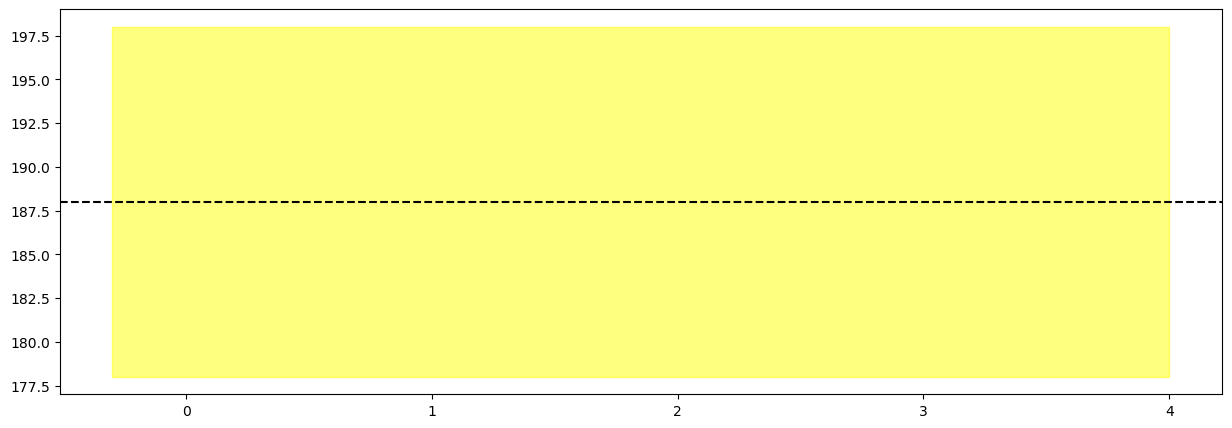

In [32]:
fig = __makeplot_comparison()

fig.savefig(config['path_to_figs']+f"BSPF_M21_baz_comparison_overview.png", dpi=200, bbox_inches='tight', pad_inches=0.05);

## Cross Spectral Density

In [ ]:
def __makeplotStream_csd2(st0, config):

    from scipy import fftpack
    from matplotlib.gridspec import GridSpec
    from scipy.signal import csd
    from numpy import array, log10
    
    import matplotlib.pyplot as plt

    st = st0.copy()
    
    NN = 5
    rot_scaling, rot_unit = 1e6, r"$\mu$rad/s"
    trans_scaling, trans_unit = 1e6, r"$\mu$m/s"
    
#     rot_scaling, rot_unit = 1, r"nrad/s"
#     trans_scaling, trans_unit = 1, r"$\mu$m/s"

    colors2 = ['darkred', 'darkgreen', 'magenta', 'tab:green', 'red', 'lightgreen']
#     colors2 = ['crimson', 'darkblue', 'red', '#3776ab', 'magenta', 'indigo']

    fig = plt.figure(figsize=(15,14))
    
    gs = GridSpec(NN, 2, figure=fig)
    
    ax1 = fig.add_subplot(gs[0, :-1])
    ax2 = fig.add_subplot(gs[1, :-1])
    ax3 = fig.add_subplot(gs[2, :-1])

    ax4 = fig.add_subplot(gs[0, 1:])
    ax5 = fig.add_subplot(gs[1, 1:])
    ax6 = fig.add_subplot(gs[2, 1:])

    ax7 = fig.add_subplot(gs[3:, :])
    
    
    font = 14
    
    plt.subplots_adjust(hspace=0.1)

    ## _______________________________________________

#     st.normalize()
    
    st.sort(keys=['channel'], reverse=True)
        
    bspf_all_data, bspf_inner_data, adr_all_data, adr_inner_data = [],[],[],[] 
    names, ffs, csds, ffs2, csds2 = [], [], [], [], []
    for comp in ["Z", "N", "E"]:
                
        tmp = st.select(channel=f"*{comp}")
        print(tmp)

        bspf_inner = tmp[0].copy()
        bspf_inner.detrend("linear")
        bspf_inner.taper(0.1)
        bspf_inner.filter("bandpass", freqmin=5, freqmax=15, corners=4, zerophase=True)
        bspf_inner.normalize()
        
        adr_inner = tmp[1].copy()
        adr_inner.detrend("linear")
        adr_inner.taper(0.1)
        adr_inner.filter("bandpass", freqmin=5, freqmax=15, corners=4, zerophase=True)
        adr_inner.normalize()
        
        nseg = int(5*tmp[0].stats.sampling_rate)
        
        ff, Pxy = csd(  
                        bspf_inner.data,
                        adr_inner.data,
                        fs=bspf_inner.stats.sampling_rate,
                        nperseg=nseg,
                        window='hann',
                        noverlap=int(0.5*nseg),
                        nfft=None,
                        detrend='constant',
                        return_onesided=True,
                        scaling='density',
                        axis=-1,
                        average='mean'
                    )
        
        names.append(f"{tmp[0].stats.channel}"+r"$_{inner}$")
        ffs.append(ff)
        csds.append(Pxy)

        adr_inner_data.append(adr_inner.data)
        bspf_inner_data.append(bspf_inner.data)
        
        ## _____________________________________
        
        bspf_all = tmp[0].copy()
        bspf_all.detrend("linear")        
        bspf_all.taper(0.1)
        bspf_all.filter("bandpass", freqmin=0.1, freqmax=1., corners=4, zerophase=True)
        bspf_all.normalize()

        adr_all = tmp[2].copy()
        adr_all.detrend("linear")
        adr_all.taper(0.1)
        adr_all.filter("bandpass", freqmin=0.1, freqmax=1., corners=4, zerophase=True)
        adr_all.normalize()        
            
        nseg = int(20*tmp[0].stats.sampling_rate)
        
        ff2, Pxy2 = csd(  
                        bspf_all.data*rot_scaling,
                        adr_all.data*rot_scaling,
                        fs=bspf_all.stats.sampling_rate,
                        nperseg=nseg,
                        window='hann',
                        noverlap=int(0.5*nseg),
                        nfft=None,
                        detrend='constant',
                        return_onesided=True,
                        scaling='spectrum',
                        axis=-1,
                        average='mean'
                    )
        
        names.append(f"{tmp[0].stats.channel}"+r"$_{all}$")
        
        ffs.append(ff2)
        csds.append(Pxy2)
        
        adr_all_data.append(adr_all.data)
        bspf_all_data.append(bspf_all.data)
        
    hz = st.select(channel="B*Z")[0]
    hn = st.select(channel="B*N")[0]
    he = st.select(channel="B*E")[0]

    jz = st.select(channel="HJZ")[0]
    jn = st.select(channel="HJN")[0]
    je = st.select(channel="HJE")[0]

    ax1.plot(hz.times(), bspf_all_data[0], 'black', label=f"BSPF.Z")
    ax2.plot(hn.times(), bspf_all_data[1], 'black', label=f"BSPF.N")
    ax3.plot(he.times(), bspf_all_data[2], 'black', label=f"BSPF.E")
    ax1.plot(hz.times(), adr_all_data[0], 'darkred', label=r"ADR$_{all}$.Z")
    ax2.plot(hn.times(), adr_all_data[1], 'darkred', label=r"ADR$_{all}$.N")
    ax3.plot(he.times(), adr_all_data[2], 'darkred', label=r"ADR$_{all}$.E")

    ax4.plot(jz.times(), bspf_inner_data[0], 'black', label=f"BSPF.Z")
    ax5.plot(jn.times(), bspf_inner_data[1], 'black', label=f"BSPF.N")
    ax6.plot(je.times(), bspf_inner_data[2], 'black', label=f"BSPF.E")
    ax4.plot(jz.times(), adr_inner_data[0], 'darkred', label=r"ADR$_{inner}$.Z")
    ax5.plot(jn.times(), adr_inner_data[1], 'darkred', label=r"ADR$_{inner}$.N")
    ax6.plot(je.times(), adr_inner_data[2], 'darkred', label=r"ADR$_{inner}$.E")


    for ii, (ff, cc, name) in enumerate(zip(ffs, csds, names)):
#         ax7.plot(ff, 20*log10(abs(cc)), label=name[2:], alpha=0.6, color=colors2[ii])
        if "all" in name:
            ax7.plot(ff, abs(cc), label=name[2:], alpha=0.6, color=colors2[ii])
        elif "inner" in name:       
            if "Z" in name:
                ax8 = ax7.twinx()
            ax8.plot(ff, abs(cc), label=name[2:], alpha=0.6, color=colors2[ii])
            

#     ax7.set_yscale("log")
    
    for ax in [ax1, ax2, ax3, ax4 ,ax5, ax6]:
        ax.legend(loc=1, fontsize=font-2, bbox_to_anchor=(0.95, 1.10), ncol=2)
        ax.set_ylabel(f"$\omega$ ({rot_unit})", fontsize=font)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        if ax not in [ax3, ax6]:
            ax.set(xticklabels=[]) 
            ax.tick_params(bottom=False)  
    
    ax7.set_xscale("log")   
    ax7.grid(which="both", ls=":", alpha=0.7, color="grey")
    ax7.legend(fontsize=font-2, ncol=3, loc=2)
    ax7.set_xlim(0.1, 20)
    ax7.set_xlabel("Frequency (Hz)", fontsize=font)
    sqrthz=r"$\sqrt{Hz}$"
#     ax7.set_ylabel(f"Cross Spectral Density \n (dB rel. to 1 nrad$^2$/s$^2$/Hz)", fontsize=font)
    ax7.set_ylabel(f"Cross Spectral Density ({rot_unit}/{sqrthz}')", fontsize=font)
    
    
    ax8.legend(fontsize=font-2, ncol=3, loc=1)
    ax8.set_ylabel(f"Cross Spectral Density ({rot_unit}/{sqrthz}')", fontsize=font, color="tab:red")
    ax8.tick_params(axis='y', colors='tab:red')
    
    ax3.set_xlabel("Time (s)", fontsize=font)
    ax6.set_xlabel("Time (s)", fontsize=font)


    bbox = list(ax7.get_position().bounds)
    bbox[3] = .85*bbox[3] # Reduce the height of the axis a bit.
    ax7.set_position(bbox)
    
    for ax in [ax1, ax2, ax3, ax4 ,ax5, ax6, ax7, ax8]:
        ax.tick_params(axis="y", labelsize=font-2)
        ax.tick_params(axis="x", labelsize=font-2)
            
#     axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#     axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    return fig

In [ ]:
# __makeplotStream_csd2(st0, config);

## Phase Velocity

In [ ]:
from functions.compute_velocity_from_amplitude_ratio import __compute_velocity_from_amplitude_ratio

In [ ]:
acc = st0.select(station="PFO*").copy()
rot = st0.select(station="BSPF").copy()
# rot = st0.select(station="RPFO", location="in").copy()

fmin, fmax = 3.0, 12.0

rot.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8)
acc.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8)

# rot.trim(rot[0].stats.starttime+10, rot[0].stats.endtime)
# acc.trim(acc[0].stats.starttime+10, acc[0].stats.endtime)

# import numpy as np
# for tr in rot:
#     tr.data = np.roll(tr.data, 1)

# acc.select(channel="*Z")[0].data *= -1
# rot.select(channel="*Z")[0].data *= -1
# rot.select(channel="*E")[0].data *= -1
# rot.select(channel="*N")[0].data *= -1

In [ ]:
out = __compute_velocity_from_amplitude_ratio(
                                                rot,
                                                acc,
                                                baz=baz,
                                                mode='love',
                                                win_time_s=1/fmin,
                                                cc_thres=0.3,
                                                overlap=0.9,
                                                flim=(fmin, fmax),
                                                plot=True,
)
out['fig'].savefig(config['path_to_figs']+f"BSPF_M21_velocity_love_{rot[0].stats.station}_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


out = __compute_velocity_from_amplitude_ratio(
                                                rot,
                                                acc,
                                                baz=baz,
                                                mode='rayleigh',
                                                win_time_s=1/fmin,
                                                cc_thres=0.3,
                                                overlap=0.9,
                                                flim=(fmin, fmax),
                                                plot=True,
)
out['fig'].savefig(config['path_to_figs']+f"BSPF_M21_velocity_rayleigh_{rot[0].stats.station}_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


# 

### Velocity in F-Bands

In [ ]:
from functions.get_octave_bands import __get_octave_bands

In [ ]:
def __estimate_velocity_in_fbands():

    flower, fupper, fcenter = __get_octave_bands(0.3, 10, fband_type="one-third-octave", plot=False)
    flower, fupper, fcenter = __get_octave_bands(0.3, 10, fband_type="octave", plot=False)
    fbands = [(f1, f2) for f1, f2 in zip(flower, fupper)]


    # fbands = [(0.5,0.7), (0.7,0.9), (0.8,1.0), (1.0,2.0), (1.0,5.0), (3.0,8.0), (5.0,12.0)]

    love_velo, rayl_velo = [], []
    r_flabels, l_flabels = [], []

    velo = np.arange(0, 5000, 250)


    for fmin, fmax in fbands:

        print(fmin, fmax)

        acc = st0.select(station="PFO").copy();
        # rot = st0.select(station="BSPF").copy();
        # rot = st0.select(station="RPFO", location="al").copy();
        # rot = st0.select(station="RPFO", location="mi").copy();
        rot = st0.select(station="RPFO", location="in").copy();

        rot = rot.detrend("demean").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8);
        acc = acc.detrend("demean").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8);

        velo = np.arange(0, 5000, 250)

        cc_threshold = 0.2
        overlap = 0.9

        out_l = __compute_velocity_from_amplitude_ratio(
                                                        rot,
                                                        acc,
                                                        baz=baz,
                                                        mode='love',
                                                        win_time_s=2/fmin,
                                                        cc_thres=cc_threshold,
                                                        overlap=overlap,
                                                        flim=(fmin, fmax),
                                                        plot=False,
        )

        lvel = out_l['velocity'][~np.isnan(out_l['velocity'])]
        if len(lvel) > 0:
            hist = np.histogram(out_l['velocity'], bins=len(velo)-1, range=[min(velo), max(velo)], weights=(out_l['ccoef']*100).astype(int), density=False)
            data = np.concatenate([np.ones(int(nnn))*val for nnn, val in zip(hist[0], hist[1])], axis=0 )
            love_velo.append(data)
            l_flabels.append(f"{round(fmin,1)}-{round(fmax,1)}Hz")

        out_r = __compute_velocity_from_amplitude_ratio(
                                                        rot,
                                                        acc,
                                                        baz=baz,
                                                        mode='rayleigh',
                                                        win_time_s=2/fmin,
                                                        cc_thres=cc_threshold,
                                                        overlap=overlap,
                                                        flim=(fmin, fmax),
                                                        plot=False,
        )

        rvel = out_r['velocity'][~np.isnan(out_r['velocity'])]
        if len(rvel) > 0:
            hist = np.histogram(out_r['velocity'], bins=len(velo)-1, range=[min(velo), max(velo)], weights=(out_r['ccoef']*100).astype(int), density=False)
            data = np.concatenate([np.ones(int(nnn))*val for nnn, val in zip(hist[0], hist[1])], axis=0 )
            rayl_velo.append(data)
            r_flabels.append(f"{round(fmin,1)}-{round(fmax,1)}Hz")


    #     plt.figure()
    #     plt.hist(out_l['velocity'], bins=len(velo)-1, range=[min(velo), max(velo)], weights=out_l['ccoef'], density=False, rwidth=0.9)
    #     plt.show();

    #     plt.figure()
    #     plt.hist(out_r['velocity'], bins=len(velo)-1, range=[min(velo), max(velo)], weights=out_r['ccoef'], density=False, rwidth=0.9)
    #     plt.show();


    fig1, ax = plt.subplots(1, 1, figsize=(15,5))

    data = love_velo

    ax.yaxis.grid(True)
    ax.violinplot(data, showmeans=False, showmedians=True, showextrema=True)

    ax.set_ylabel("Love Phase Velocity (m/s)")
    ax.set_xticks([y + 1 for y in range(len(data))], labels=l_flabels)

    if rot[0].stats.station == "RPFO":
        ax.set_title(f" {acc[0].stats.station} - {rot[0].stats.station}{rot[0].stats.location[0]} | Overlap = {int(overlap*100)} % | CC_limit = {cc_threshold}")
    else:
        ax.set_title(f" {acc[0].stats.station} - {rot[0].stats.station} | Overlap = {int(overlap*100)} % | CC_limit = {cc_threshold}")


    plt.show();




    fig2, ax = plt.subplots(1, 1, figsize=(15,5))

    data = rayl_velo

    ax.yaxis.grid(True)
    out2 = ax.violinplot(data, showmeans=False, showmedians=True, showextrema=True)

    ax.set_ylabel("Rayleigh Phase Velocity (m/s)")
    ax.set_xticks([y + 1 for y in range(len(data))], labels=r_flabels)

    if rot[0].stats.station == "RPFO":
        ax.set_title(f" {acc[0].stats.station} - {rot[0].stats.station}{rot[0].stats.location[0]} | Overlap = {int(overlap*100)} % | CC_limit = {cc_threshold}")
    else:
        ax.set_title(f" {acc[0].stats.station} - {rot[0].stats.station} | Overlap = {int(overlap*100)} % | CC_limit = {cc_threshold}")

    plt.show();
    return fig1, fig2

In [ ]:
fig1, fig2 = __estimate_velocity_in_fbands()


fig1.savefig(config['path_to_figs']+f"BSFP_M21_Love_velocity_fbands_{rot[0].stats.station}.png", format="png", dpi=200, bbox_inches='tight')

fig2.savefig(config['path_to_figs']+f"BSFP_M21_Rayleigh_velocity_fbands_{rot[0].stats.station}_{rot[0].stats.location}.png", format="png", dpi=200, bbox_inches='tight')